In [ ]:
import numpy as np
from pandas import read_csv
from keras.models import Sequential

from keras.layers import Conv1D,MaxPooling1D,Dense,Flatten,Dropout,LSTM,Bidirectional

from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.utils import plot_model
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# set seed to reproduce similar results
np.random.seed(0)

In [ ]:

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
dataset_file_id = '1xnD6OXIMNOChR4V9DKO-Jjsb7QNMUjc0'

In [ ]:
downloaded = drive.CreateFile({'id':dataset_file_id})
downloaded.GetContentFile('UCI HAR Dataset.zip')

In [ ]:
!unzip "/content/UCI HAR Dataset.zip" -d "/content/"


Archive:  /content/UCI HAR Dataset.zip
   creating: /content/UCI HAR Dataset/
  inflating: /content/UCI HAR Dataset/.DS_Store  
   creating: /content/__MACOSX/
   creating: /content/__MACOSX/UCI HAR Dataset/
  inflating: /content/__MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: /content/UCI HAR Dataset/activity_labels.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: /content/UCI HAR Dataset/features.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._features.txt  
  inflating: /content/UCI HAR Dataset/features_info.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: /content/UCI HAR Dataset/README.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._README.txt  
   creating: /content/UCI HAR Dataset/test/
   creating: /content/UCI HAR Dataset/test/Inertial Signals/
  inflating: /content/UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: /content/__MACOSX/UCI HAR Dataset/test/
   

In [ ]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [ ]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
trainX, trainy, testX, testy = load_dataset()


trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [ ]:
batch_size = 64
validation_split = 0.2

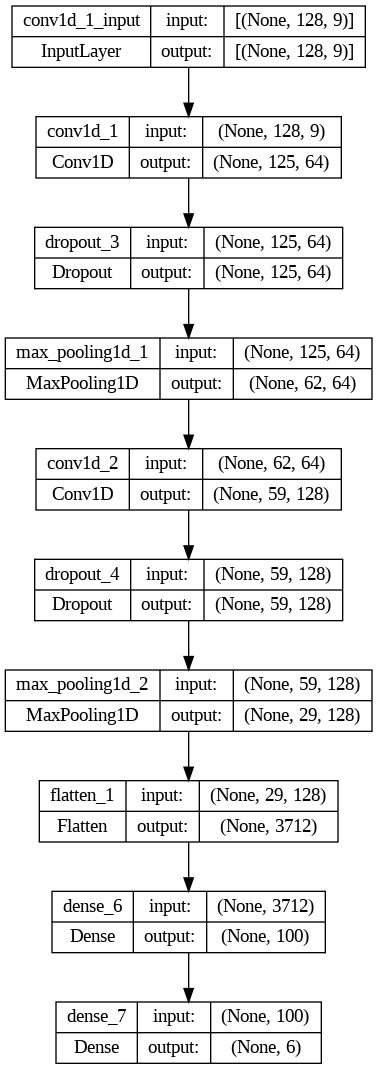

In [ ]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# fit network
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
92/92 [==============================] - 4s 32ms/step - loss: 0.6014 - accuracy: 0.7494 - val_loss: 0.5327 - val_accuracy: 0.8973
Epoch 2/20
92/92 [==============================] - 3s 31ms/step - loss: 0.2153 - accuracy: 0.9206 - val_loss: 0.3626 - val_accuracy: 0.9103
Epoch 3/20
92/92 [==============================] - 3s 31ms/step - loss: 0.1247 - accuracy: 0.9486 - val_loss: 0.3293 - val_accuracy: 0.9069
Epoch 4/20
92/92 [==============================] - 3s 36ms/step - loss: 0.1060 - accuracy: 0.9553 - val_loss: 0.3111 - val_accuracy: 0.9109
Epoch 5/20
92/92 [==============================] - 3s 31ms/step - loss: 0.1002 - accuracy: 0.9577 - val_loss: 0.2904 - val_accuracy: 0.9062
Epoch 6/20
92/92 [==============================] - 3s 30ms/step - loss: 0.0876 - accuracy: 0.9592 - val_loss: 0.3036 - val_accuracy: 0.9123
Epoch 7/20
92/92 [==============================] - 4s 40ms/step - loss: 0.0885 - accuracy: 0.9587 - val_loss: 0.2888 - val_accuracy: 0.9103
Epoch 8/20
92

In [ ]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy", test_accuracy)

Accuracy of the CNN model 0.9236511588096619
93/93 [==============================] - 0s 4ms/step
